In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 

import pickle

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D 

# plotting functions

In [2]:
# use custom style sheet 
plt.style.use('sonoma.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#custom colormap for phase diagrams
wc_colors = ["#c6423c", "#fafafa", "#4454c2"]  # red → white → blue
warmcool = LinearSegmentedColormap.from_list("warmcool", wc_colors)

def unpickle(file):
    with open(file, "rb") as f:
        dat = pickle.load(f)
    return dat

def scratch_ge_theory(gamma, sigma):
    ge = np.where(gamma < 1, ((1-gamma)**2 + gamma*sigma**2)/(1-gamma), sigma**2 / (gamma-1))
    return ge

def lt_theory(theta, gamma, sigma, lam=0):
    scratch = scratch_ge_theory(gamma, sigma)
    T = scratch - (1 - ((1 + 2*lam)/(1 + lam)**2) * np.cos(theta)**2)
    return T

def ft_theory(theta, gamma):
    T = np.where(gamma < 1, (gamma-1) * (1 - 2*np.cos(theta)), 0)
    return T

def make_phase_plot(phase_arr, theta_list, gamma_list, save=None, colorbar=True, binary=False, contour=False):
    theta_labels = [r'$0$', r'$\pi/6$', r'$\pi/3$', r'$\pi/2$']
    gamma_labels = ['0', '0.5', '1.0', '1.5', '2.0']
    theta_tick_positions = np.linspace(0,len(theta_list)-1, len(theta_labels))
    gamma_tick_positions = np.linspace(0,len(gamma_list)-1, len(gamma_labels))
    alpha=1
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if binary:
        phase_arr[phase_arr > 0] = 1
        phase_arr[phase_arr < 0] = -1
        phase_arr[phase_arr == 0] = 0
        alpha=0.55

    if contour:
        theta_tick_positions = np.linspace(theta_list.min(), theta_list.max(), len(theta_labels))
        gamma_tick_positions = np.linspace(gamma_list.min(), gamma_list.max(), len(gamma_labels))
        X,Y = np.meshgrid(theta_list, gamma_list)
        im = ax.imshow(phase_arr, origin='lower', aspect='equal',
               extent=[theta_list.min(), theta_list.max(), gamma_list.min(), gamma_list.max()],
               cmap=warmcool, alpha=alpha)
        contours = ax.contour(X, Y, phase_arr, levels=[0.0], colors='black', linewidths=1.75)
        ax.set_aspect((theta_list.max() - theta_list.min()) /
              (gamma_list.max() - gamma_list.min()))
    else:
        im = ax.imshow(phase_arr, origin='lower', cmap=warmcool, vmin=-1, vmax=1, alpha=alpha)
        
    
    if colorbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    ax.set_xticks(theta_tick_positions)
    ax.set_yticks(gamma_tick_positions)
    ax.set_xticklabels(theta_labels)
    ax.set_yticklabels(gamma_labels)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\gamma$', rotation=True, labelpad=15)
    plt.tight_layout()
    
    if save:
        plt.savefig(save)
        
    plt.show()

def make_slice_plots(exp_arr, exp_x, slices, theory_x, func, ylim=None, save=None, **args):
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    counter = 0
    for index, angle in slices.items():
        ax.plot(theory_x, func(angle, theory_x, **args), color=colors[counter], label=labels[counter])
        ax.errorbar(exp_x, exp_arr[:,:,index].mean(0), exp_arr[:,:,index].std(0), marker='o', alpha=0.6, linestyle='')
        counter += 1
    ax.set_xlabel(r"$\gamma$")
    if ylim:
        ax.set_ylim(ylim)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()


def make_3d_plot(func, save=None, **args):
    n = 200
    theta_vals = np.linspace(0, np.pi/2, n)
    gamma_vals = np.linspace(0, 2.0, n)
    T_mesh, G_mesh = np.meshgrid(theta_vals, gamma_vals)
    Z = func(T_mesh, G_mesh, **args) 
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(T_mesh, G_mesh, Z, color=colors[1], edgecolor='none', antialiased=True, alpha=0.8)
    ax.view_init(elev=10, azim=45)
    ax.set_zlim(-1,1)
    
    ax.set_xlabel(r'$\theta$', labelpad=10)
    ax.set_ylabel(r'$\gamma$', labelpad=10)
    
    ax.set_xticks([0, np.pi/6, np.pi/3, np.pi/2])
    ax.set_xticklabels([r"$0$", r"$\pi/6$", r"$\pi/3$", r"$\pi/2$"])
    ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
    ax.set_zticks([-1.0, -0.5, 0.0, 0.5, 1.0])

    if save:
        plt.savefig(save)
    
    plt.show()


# set file paths

In [3]:
# experimental parameters
l = 2 
d = 500
seed = 1
instances = 20
n_list = np.array([int(50 + (50 * i)) for i in range(20)])              #number of target data points
wd_list = [0.0, 0.0001, 0.001, 0.01, 0.1]                               #weight decay strengths
ridge_list= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]                              #ridge regularization strengths
theta_list = np.array([round(0.05 + (0.05 * i), 2) for i in range(20)]) #fraction of pi/2

# directory and file name
dir = os.getcwd() + f"/l={l}-d={d}/"
plot_path = dir + "plots/"
scratch_fname = lambda noise, seed, n: dir + f"noise={noise}/scratch/noise={float(noise)}-seed={seed}-n={n}-dict.p" 
transfer_fname = lambda noise, n_src, theta, seed, n_tar: dir + f"noise={noise}/n_src={n_src}-theta={theta}-seed={seed}-n_tar={n_tar}-dict.p"

# infinite source data

In [4]:
n_src = None

## $\sigma = 0.2$

In [5]:
noise = 0.2

### scratch training

In [6]:
scratch_ge = {wd: np.zeros((instances, len(n_list))) for wd in wd_list}
for i,n in enumerate(n_list):
    train_dict = unpickle(scratch_fname(noise, seed, n))
    for wd in wd_list:
        scratch_ge[wd][:,i] = train_dict[wd]['train_dict']['ge_stream'][-1]

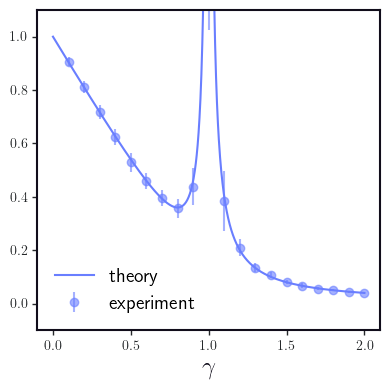

In [7]:
gamma_theory = np.linspace(0,2,1000)
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(gamma_theory, scratch_ge_theory(gamma_theory, noise), color=colors[0], label='theory')
ax.errorbar(n_list/d, scratch_ge[0.0].mean(0), scratch_ge[0.0].std(0), marker='o', linestyle='', alpha=0.6, color=colors[0], label='experiment')
ax.set_xlabel(r"$\gamma$")
ax.set_ylim(-0.1,1.1)
plt.tight_layout()
plt.legend()
plt.savefig(plot_path + f'scratch_ge-noise={noise}.pdf')
plt.show()

### phase diagrams + slices

In [8]:
# collect data 
lt_ge = np.zeros((instances, len(n_list), len(theta_list)))
ft_ge = np.zeros((instances, len(n_list), len(theta_list)))

for i,n in enumerate(n_list):
    for j,theta in enumerate(theta_list):
        dict = unpickle(transfer_fname(noise, n_src, theta, seed, n))
        lt_ge[:,i,j] = dict['lt_dict'][0.1]['ge']              #chose reg=0.1 because unregularized version was unstable with lstsq func. to avoid, just add very small regularizer
        ft_ge[:,i,j] = dict['ft_dict']['ge_stream'][-1]

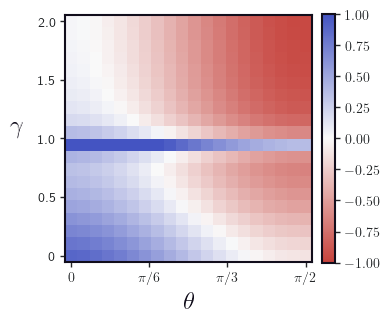

In [14]:
scratch_block = np.tile(scratch_ge[0.0][:,:,None], (1,1,len(theta_list)))
lt_phase = scratch_block - lt_ge
ft_phase = scratch_block - ft_ge

make_phase_plot(lt_phase.mean(0), theta_list, n_list, save=plot_path + 'noise=0.2-lt_phase-exp.pdf')
#make_phase_plot(ft_phase.mean(0), theta_list, n_list, save=plot_path + 'noise=0.2-ft_phase-exp.pdf')   #this plot is slightly off

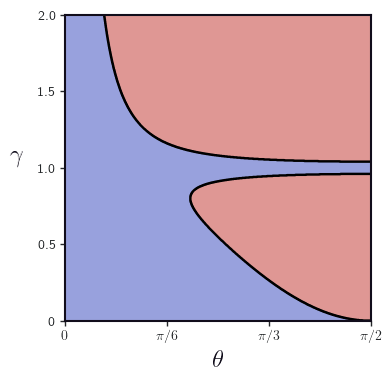

In [10]:
n_cells = 1000
theta_vals = np.linspace(0, np.pi/2, n_cells)
gamma_vals = np.linspace(0, 2, n_cells)
T, G = np.meshgrid(theta_vals, gamma_vals)
lt_ = lt_theory(T,G, sigma=noise) 
ft_ = ft_theory(T,G)

make_phase_plot(lt_, theta_vals, gamma_vals, colorbar=False, binary=True, contour=True, save=plot_path + 'noise=0.2-lt_phase-theory_binary.pdf')

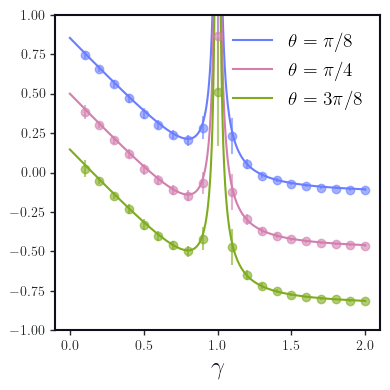

In [11]:
slices = {int(0.25 / 0.05)-1: np.pi/8, int(0.5 / 0.05)-1: np.pi/4, int(0.75 / 0.05)-1: 3*np.pi/8}
labels = [r"$\theta = \pi/8$", r"$\theta = \pi/4$",r"$\theta = 3\pi/8$"]

make_slice_plots(lt_phase, n_list/d, slices, gamma_vals, lt_theory, ylim=(-1,1), save=plot_path + 'noise=0.2-lt_slices.pdf', sigma=noise)
#make_slice_plots(ft_phase, n_list/d, slices, gamma_vals, ft_theory)

### 3d plots

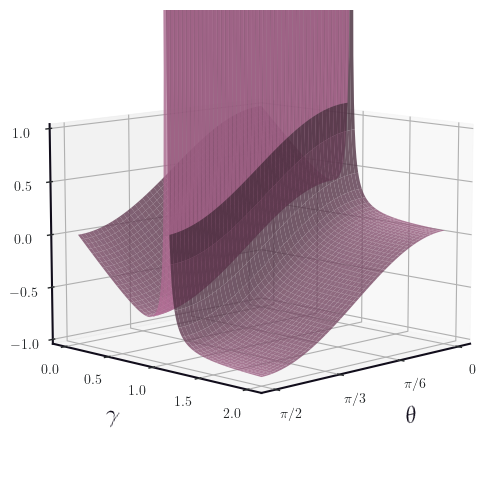

In [22]:
make_3d_plot(lt_theory, sigma=0.2, save= plot_path + 'noise=0.2-lt_surface.pdf')

### ridge regularization

In [24]:
lt_ge_ridge = np.zeros((instances, len(ridge_list), len(n_list), len(theta_list)))

for i,n in enumerate(n_list):
    for j,theta in enumerate(theta_list):
        dict = unpickle(transfer_fname(noise, n_src, theta, seed, n))
        for r, reg in enumerate(ridge_list):
            lt_ge_ridge[:,r,i,j] = dict['lt_dict'][reg]['ge']              
        

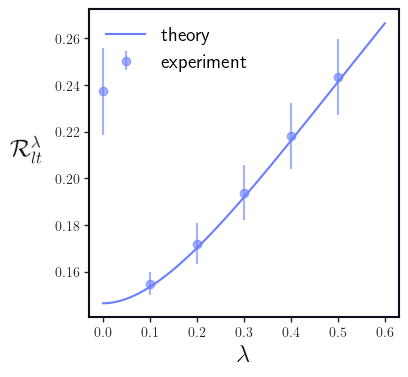

In [57]:
gamma_val = 0.5
gamma_ind = np.where(n_list/d == gamma_val)[0][0]
theta_val = 0.25
theta_ind = np.where(theta_list == theta_val)[0][0]
lam_theory = np.linspace(0,0.6,250)
ge_ridge_theory = 1 - (1 + 2*lam_theory)/(1 + lam_theory)**2 * np.cos(theta_val * np.pi * 0.5)**2

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(lam_theory, ge_ridge_theory, color=colors[0], label='theory')
ax.errorbar(np.array(ridge_list), lt_ge_ridge[:, :, gamma_ind, theta_ind].mean(0), lt_ge_ridge[:, :, gamma_ind, theta_ind].std(0), marker='o', linestyle='', alpha=0.6, color=colors[0], label='experiment')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('$\mathcal{R}^{\lambda}_{lt}$', rotation=True, labelpad=20)
plt.legend()
plt.savefig(plot_path + 'ridge_reg_lt.pdf')
plt.show()



### weight decay in source training

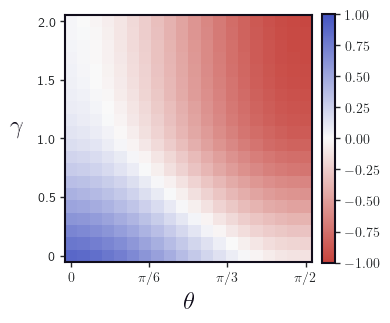

In [23]:
scratch_ge_wd = np.stack([scratch_ge[k] for k in scratch_ge.keys()])
scratch_ge_wd = np.tile(scratch_ge_wd[:,:,:,None], (1,1,1,len(theta_list)))
opt_scratch_ge = np.min(scratch_ge_wd.mean(1), axis=0)
opt_lt_phase = opt_scratch_ge - lt_ge.mean(0)

make_phase_plot(opt_lt_phase, theta_list, n_list/d, save= plot_path + 'noise=0.2-lt_phase-wd.pdf')

# $\sigma = 0$

In [56]:
noise = 0.0

### scratch training

In [7]:
scratch_ge = {wd: np.zeros((instances, len(n_list))) for wd in wd_list}
for i,n in enumerate(n_list):
    train_dict = unpickle(scratch_fname(noise, seed, n))
    for wd in wd_list:
        scratch_ge[wd][:,i] = train_dict[wd]['train_dict']['ge_stream'][-1]

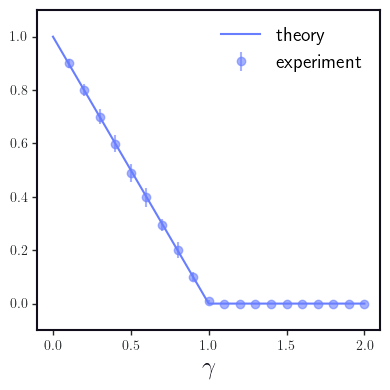

In [58]:
gamma_theory = np.linspace(0,2,1000)
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(gamma_theory, scratch_ge_theory(gamma_theory, noise), color=colors[0], label='theory')
ax.errorbar(n_list/d, scratch_ge[0.0].mean(0), scratch_ge[0.0].std(0), marker='o', linestyle='', alpha=0.6, color=colors[0], label='experiment')
ax.set_xlabel(r"$\gamma$")
ax.set_ylim(-0.1,1.1)
plt.tight_layout()
plt.legend()
plt.savefig(plot_path + f'scratch_ge-noise={noise}.pdf')
plt.show()

### phase diagrams 

In [59]:
# collect data 
lt_ge = np.zeros((instances, len(n_list), len(theta_list)))
ft_ge = np.zeros((instances, len(n_list), len(theta_list)))

for i,n in enumerate(n_list):
    for j,theta in enumerate(theta_list):
        dict = unpickle(transfer_fname(noise, n_src, theta, seed, n))
        lt_ge[:,i,j] = dict['lt_dict'][0.1]['ge']              #chose reg=0.1 because unregularized version was unstable with lstsq func. to avoid, just add very small regularizer
        ft_ge[:,i,j] = dict['ft_dict']['ge_stream'][-1]

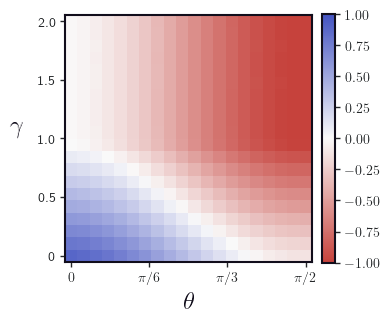

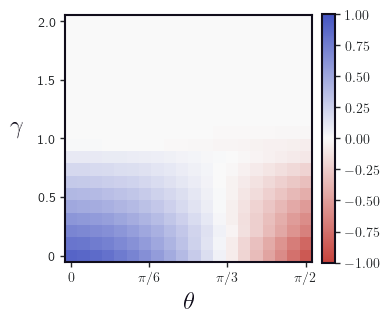

In [60]:
scratch_block = np.tile(scratch_ge[0.0][:,:,None], (1,1,len(theta_list)))
lt_phase = scratch_block - lt_ge
ft_phase = scratch_block - ft_ge

make_phase_plot(lt_phase.mean(0), theta_list, n_list, save=plot_path + 'noise=0-lt_phase-exp.pdf')
make_phase_plot(ft_phase.mean(0), theta_list, n_list, save=plot_path + 'noise=0-ft_phase-exp.pdf')

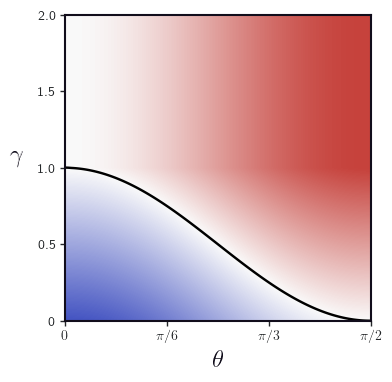

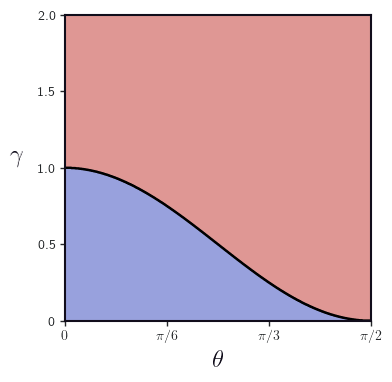

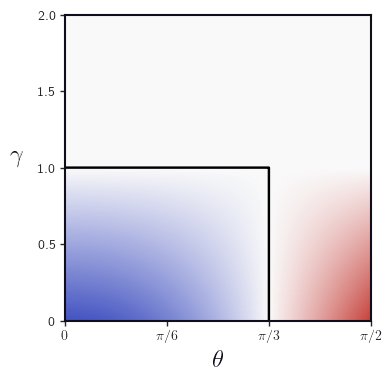

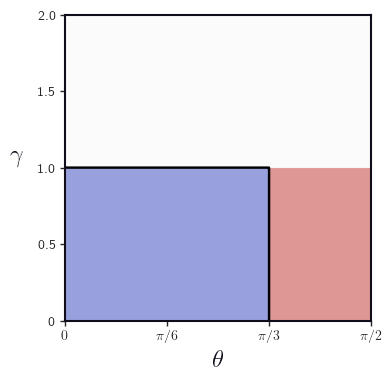

In [40]:
n_cells = 1000
theta_vals = np.linspace(0, np.pi/2, n_cells)
gamma_vals = np.linspace(0, 2, n_cells)
T, G = np.meshgrid(theta_vals, gamma_vals)
lt_ = lt_theory(T,G, sigma=0) 
ft_ = ft_theory(T,G)

make_phase_plot(lt_, theta_vals, gamma_vals, colorbar=False, binary=False, contour=True, save=plot_path + 'noise=0-lt_phase-theory_shaded.pdf')
make_phase_plot(lt_, theta_vals, gamma_vals, colorbar=False, binary=True, contour=True, save=plot_path + 'noise=0-lt_phase-theory_binary.pdf')
make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=False, contour=True, save=plot_path + 'noise=0-ft_phase-theory_shaded.pdf')
make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=True, contour=True, save=plot_path + 'noise=0-ft_phase-theory_binary.pdf')

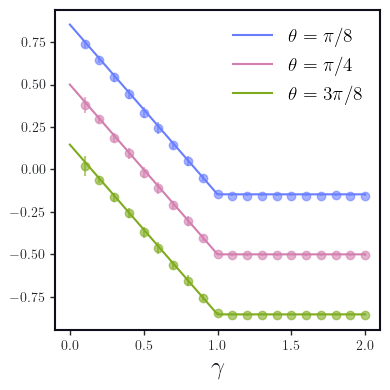

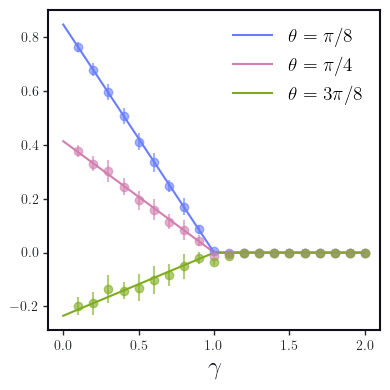

In [47]:
slices = {int(0.25 / 0.05)-1: np.pi/8, int(0.5 / 0.05)-1: np.pi/4, int(0.75 / 0.05)-1: 3*np.pi/8}
labels = [r"$\theta = \pi/8$", r"$\theta = \pi/4$",r"$\theta = 3\pi/8$"]

make_slice_plots(lt_phase, n_list/d, slices, gamma_vals, lt_theory, save=plot_path + 'noise=0-lt_slices.pdf', sigma=noise)
make_slice_plots(ft_phase, n_list/d, slices, gamma_vals, ft_theory, save=plot_path + 'noise=0-ft_slices.pdf')

### 3d plots 

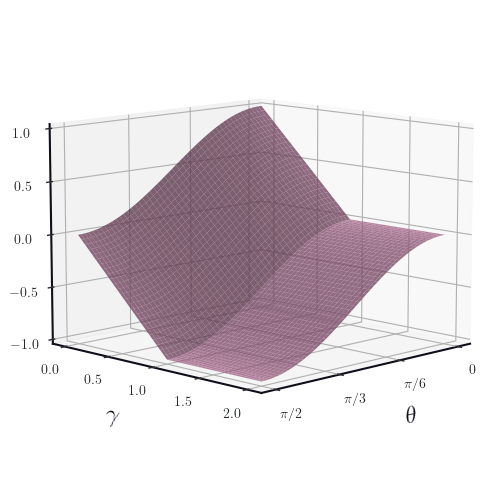

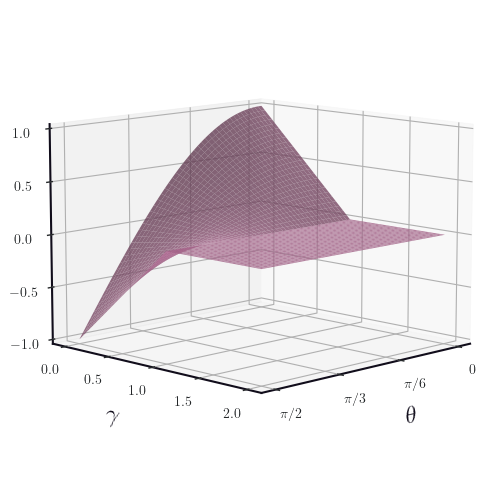

In [34]:
make_3d_plot(lt_theory, save = plot_path + "noise=0-lt_surf.pdf", sigma=0)
make_3d_plot(ft_theory, save = plot_path + "ft_surf.pdf")

# finite source data 

In [4]:
def ft_theory_finite_src(theta, gt, gs, sigma_s):
    if gs < 1:
        t = gs * (1 - 2*np.cos(theta)) + (sigma_s**2 * gs)/(1 - gs)
    else:
        t = (1 - 2*np.cos(theta)) + (sigma_s**2)/(gs - 1)
    return -((1-gt > 0) * (1 - gt)) * t

In [5]:
noise = 0.2

scratch_ge = {wd: np.zeros((instances, len(n_list))) for wd in wd_list}
for i,n in enumerate(n_list):
    train_dict = unpickle(scratch_fname(noise, seed, n))
    for wd in wd_list:
        scratch_ge[wd][:,i] = train_dict[wd]['train_dict']['ge_stream'][-1]

## $\gamma_s = 0.5$ ($n_{\text{src}} = 250$)

In [6]:
n_src = 250
seed = 0

In [7]:
# collect data 
lt_ge = np.zeros((instances, len(n_list), len(theta_list)))
ft_ge = np.zeros((instances, len(n_list), len(theta_list)))

for i,n in enumerate(n_list):
    for j,theta in enumerate(theta_list):
        dict = unpickle(transfer_fname(noise, n_src, theta, seed, n))
        lt_ge[:,i,j] = dict['lt_dict'][0.1]['ge']              #chose reg=0.1 because unregularized version was unstable with lstsq func. to avoid, just add very small regularizer
        ft_ge[:,i,j] = dict['ft_dict']['ge_stream'][-1]

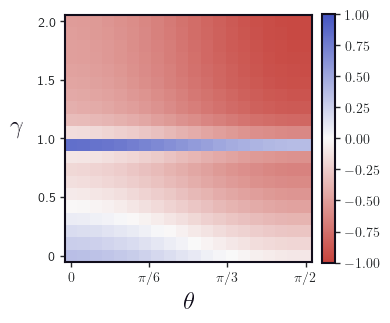

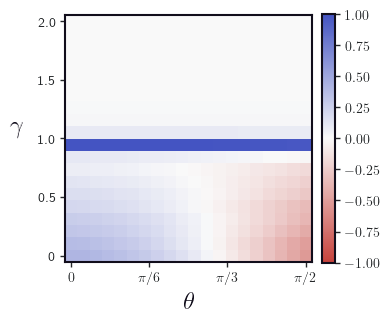

In [8]:
scratch_block = np.tile(scratch_ge[0.0][:,:,None], (1,1,len(theta_list)))
lt_phase = scratch_block - lt_ge
ft_phase = scratch_block - ft_ge

make_phase_plot(lt_phase.mean(0), theta_list, n_list, save=plot_path + f'noise={noise}-lt_phase_gs=0.5-exp.pdf')
make_phase_plot(ft_phase.mean(0), theta_list, n_list, save=plot_path + f'noise={noise}-ft_phase_gs=0.5-exp.pdf')

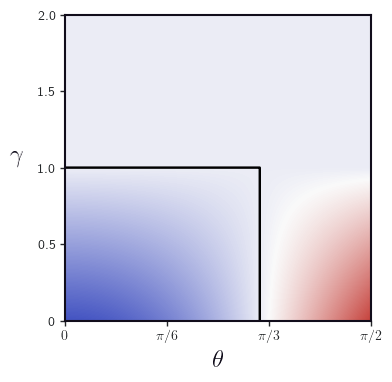

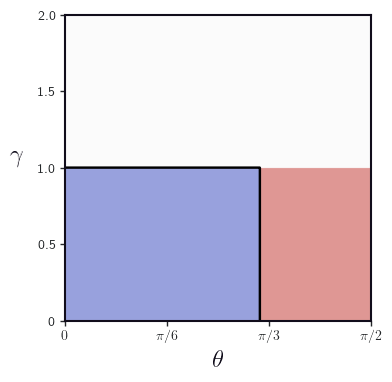

In [9]:
n_cells = 1000
theta_vals = np.linspace(0, np.pi/2, n_cells)
gamma_vals = np.linspace(0, 2, n_cells)
T, G = np.meshgrid(theta_vals, gamma_vals)
ft_ = ft_theory_finite_src(T,G, n_src/d, noise)

make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=False, contour=True, save=plot_path + f'noise={noise}-ft_g_s=0.5_phase-theory_shaded.pdf')
make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=True, contour=True, save=plot_path + f'noise={noise}-ft_g_s=0.5-phase-theory_binary.pdf')

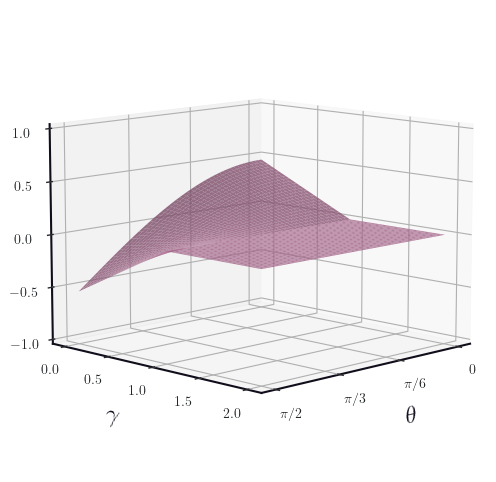

In [14]:
make_3d_plot(ft_theory_finite_src, gs=n_src/d, sigma_s=noise)

## $\gamma = 1.5$ ($n_{\text{src}} = 750$)

In [14]:
n_src = 750 
seed = 0

In [15]:
# collect data 
lt_ge = np.zeros((instances, len(n_list), len(theta_list)))
ft_ge = np.zeros((instances, len(n_list), len(theta_list)))

for i,n in enumerate(n_list):
    for j,theta in enumerate(theta_list):
        dict = unpickle(transfer_fname(noise, n_src, theta, seed, n))
        lt_ge[:,i,j] = dict['lt_dict'][0.1]['ge']              #chose reg=0.1 because unregularized version was unstable with lstsq func. to avoid, just add very small regularizer
        ft_ge[:,i,j] = dict['ft_dict']['ge_stream'][-1]

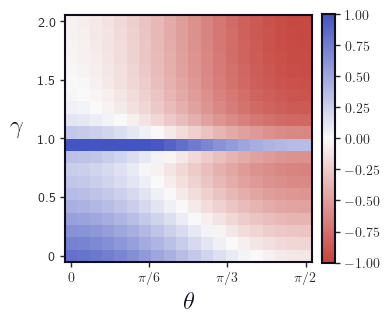

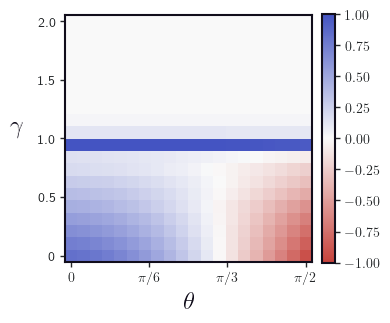

In [16]:
scratch_block = np.tile(scratch_ge[0.0][:,:,None], (1,1,len(theta_list)))
lt_phase = scratch_block - lt_ge
ft_phase = scratch_block - ft_ge

make_phase_plot(lt_phase.mean(0), theta_list, n_list, save=plot_path + f'noise={noise}-lt_phase_gs=1.5-exp.pdf')
make_phase_plot(ft_phase.mean(0), theta_list, n_list, save=plot_path + f'noise={noise}-ft_phase_gs=1.5-exp.pdf')

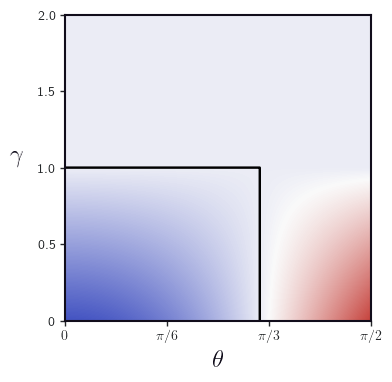

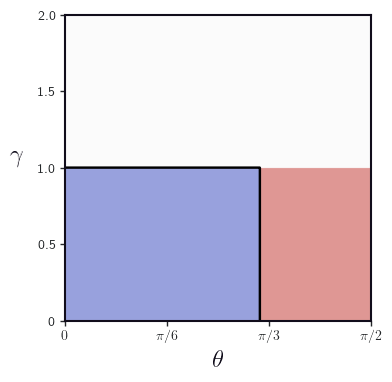

In [17]:
n_cells = 1000
theta_vals = np.linspace(0, np.pi/2, n_cells)
gamma_vals = np.linspace(0, 2, n_cells)
T, G = np.meshgrid(theta_vals, gamma_vals)
ft_ = ft_theory_finite_src(T,G, n_src/d, noise)

make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=False, contour=True, save=plot_path + f'noise={noise}-ft_g_s=1.5_phase-theory_shaded.pdf')
make_phase_plot(ft_, theta_vals, gamma_vals, colorbar=False, binary=True, contour=True, save=plot_path + f'noise={noise}-ft_g_s=1.5-phase-theory_binary.pdf')